First five rows:
   age  fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

   income_level  
0             0  
1             0  
2             0  
3             0  
4             0  

Dataset shape: (48842, 7)

Numerical columns: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical columns: []
Initial test accuracy (n_estimators=10): 0.8257
n_estimators=10: CV mean accuracy=0.8201
n_estimators=20: CV mean accuracy=0.8228
n_estimators=30: CV mean accuracy=0.8250
n_estimators=40: CV mean accuracy=0.8291
n_estimators=50: CV mean accuracy=0.8291
n_e

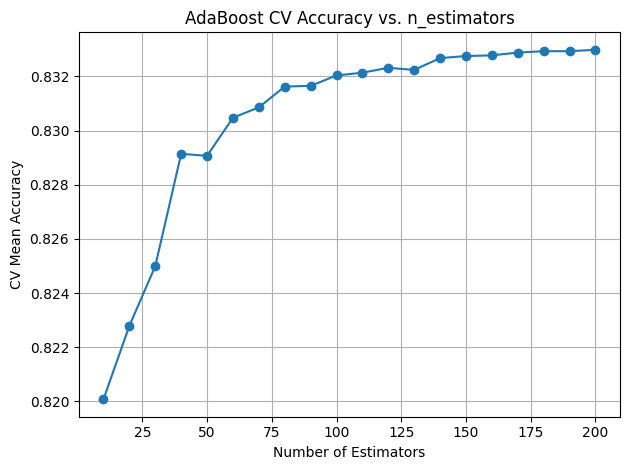


Best CV accuracy=0.8330 with n_estimators=200
Test accuracy with best n_estimators (200): 0.8344


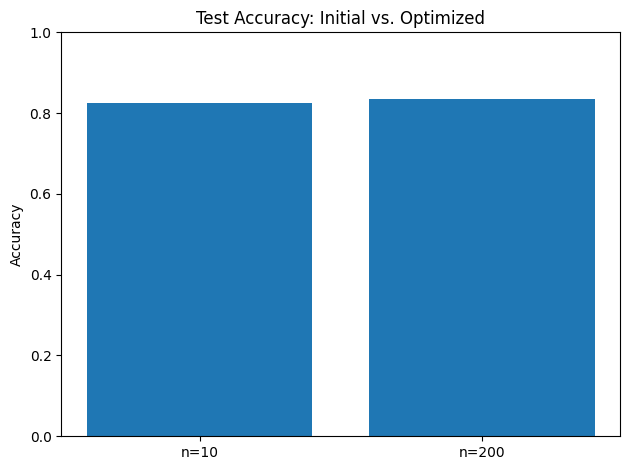

<Figure size 640x480 with 0 Axes>

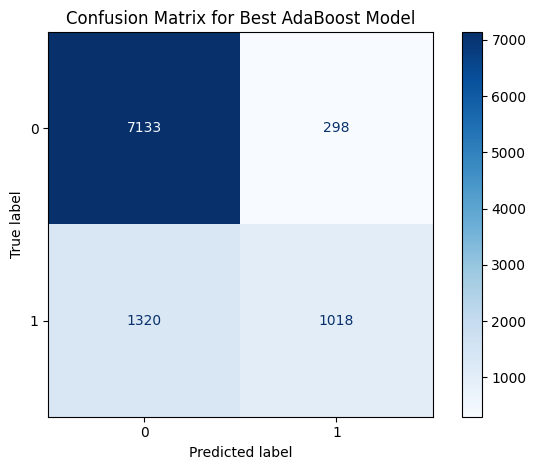

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load dataset
data = pd.read_csv('income.csv')

# Display basic info
print("First five rows:")
print(data.head())
print(f"\nDataset shape: {data.shape}")

# Define features and target
target_column = 'income_level'
y = data[target_column]
X = data.drop(columns=[target_column])

# Identify categorical vs numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Preprocessor: scale numericals, one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Initial AdaBoost model with 10 estimators
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', AdaBoostClassifier(n_estimators=10, random_state=42))
])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train and evaluate initial model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
initial_acc = accuracy_score(y_test, y_pred)
print(f"Initial test accuracy (n_estimators=10): {initial_acc:.4f}")

# Hyperparameter tuning: find best n_estimators
tree_counts = list(range(10, 201, 10))  # 10,20,...,200
cv_scores = []
for n in tree_counts:
    model = Pipeline([
        ('preprocess', preprocessor),
        ('clf', AdaBoostClassifier(n_estimators=n, random_state=42))
    ])
    scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
    )
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"n_estimators={n}: CV mean accuracy={mean_score:.4f}")

# Plot CV accuracy vs. number of estimators
plt.figure()
plt.plot(tree_counts, cv_scores, marker='o')
plt.title('AdaBoost CV Accuracy vs. n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('CV Mean Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# Determine optimal number of trees
best_score = max(cv_scores)
best_n = tree_counts[cv_scores.index(best_score)]
print(f"\nBest CV accuracy={best_score:.4f} with n_estimators={best_n}")

# Retrain and evaluate best model
best_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', AdaBoostClassifier(n_estimators=best_n, random_state=42))
])
best_model.fit(X_train, y_train)
y_best = best_model.predict(X_test)
best_test_acc = accuracy_score(y_test, y_best)
print(f"Test accuracy with best n_estimators ({best_n}): {best_test_acc:.4f}")

# Plot comparison of initial vs. best test accuracy
plt.figure()
plt.bar(['n=10', f'n={best_n}'], [initial_acc, best_test_acc])
plt.title('Test Accuracy: Initial vs. Optimized')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot confusion matrix for best model
cm = confusion_matrix(y_test, y_best)
labels = best_model.named_steps['clf'].classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure()
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best AdaBoost Model')
plt.tight_layout()
plt.show()
